<a href="https://colab.research.google.com/github/patofw/imf_master/blob/master/Notebooks/ML_Sentiment_Analysis.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
!pip install -U pyspellchecker
!pip install emoji


     |████████████████████████████████| 1.9MB 5.7MB/s 
     |████████████████████████████████| 51kB 2.8MB/s 
  Created wheel for emoji: filename=emoji-0.5.4-cp36-none-any.whl size=42176 sha256=d7440c72aecd73090f7596352d19462c13b2694d0083341ef665538553c35c19
  Stored in directory: /root/.cache/pip/wheels/2a/a9/0a/4f8e8cce8074232aba240caca3fade315bb49fac68808d1a9c
Successfully built emoji


# Análisis de sentimiento basado en Machine Learning 

En la anterior clase desarrollamos un modelo de análisis de sentimiento basado en un diccionario de palabras pre-asignadas (VADER), que ha demostrado ser eficiente, rápido y sencillo. Sin embargo, también hemos podido ver que tiene importantes limitaciones, sobre todo en entender el contexto que rodea a una oración. 

Ahora vamos a ver una aproximación diferente para resolver el mismo problema. Crearemos algoritmos de Machine Learning para tratar de capturar el sentimiento que esconde una frase. Sin embargo, para este ejercicio vamos a necesitar un dataset con 'tags' que nos permitan entrenar el modelo. 

Por ello, utilizaremos una fuente de Tweets ya pre-taggeados de las compañías aéreas americanas. Como siempre, primero limpiaremos los datos y luego pasaremos a modelarlos.

In [2]:
import pandas as pd 
import numpy as np 
import matplotlib.pyplot as plt
import seaborn as sns 
%matplotlib inline
# cargamos datos 
url = 'https://raw.githubusercontent.com/patofw/imf_master/master/Notebooks/data/Tweets.csv'
data = pd.read_csv(url)
data.head()


/usr/local/lib/python3.6/dist-packages/statsmodels/tools/_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


,tweet_id,airline_sentiment,airline_sentiment_confidence,negativereason,negativereason_confidence,airline,airline_sentiment_gold,name,negativereason_gold,retweet_count,text,tweet_coord,tweet_created,tweet_location,user_timezone
0,570306133677760513,neutral,1.0000,NaN,NaN,Virgin America,NaN,cairdin,NaN,0,@VirginAmerica What @dhepburn said.,NaN,2015-02-24 11:35:52 -0800,NaN,Eastern Time (US & Canada)
1,570301130888122368,positive,0.3486,NaN,0.0000,Virgin America,NaN,jnardino,NaN,0,@VirginAmerica plus you've added commercials t...,NaN,2015-02-24 11:15:59 -0800,NaN,Pacific Time (US & Canada)
2,570301083672813571,neutral,0.6837,NaN,NaN,Virgin America,NaN,yvonnalynn,NaN,0,@VirginAmerica I didn't today... Must mean I n...,NaN,2015-02-24 11:15:48 -0800,Lets Play,Central Time (US & Canada)
3,570301031407624196,negative,1.0000,Bad Flight,0.7033,Virgin America,NaN,jnardino,NaN,0,@VirginAmerica it's really aggressive to blast...,NaN,2015-02-24 11:15:36 -0800,NaN,Pacific Time (US & Canada)
4,570300817074462722,negative,1.0000,Can't Tell,1.0000,Virgin America,NaN,jnardino,NaN,0,@VirginAmerica and it's a really big bad thing...,NaN,2015-02-24 11:14:45 -0800,NaN,Pacific Time (US & Canada)


In [3]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 14640 entries, 0 to 14639
Data columns (total 15 columns):
 #   Column                        Non-Null Count  Dtype  
---  ------                        --------------  -----  
 0   tweet_id                      14640 non-null  int64  
 1   airline_sentiment             14640 non-null  object 
 2   airline_sentiment_confidence  14640 non-null  float64
 3   negativereason                9178 non-null   object 
 4   negativereason_confidence     10522 non-null  float64
 5   airline                       14640 non-null  object 
 6   airline_sentiment_gold        40 non-null     object 
 7   name                          14640 non-null  object 
 8   negativereason_gold           32 non-null     object 
 9   retweet_count                 14640 non-null  int64  
 10  text                          14640 non-null  object 
 11  tweet_coord                   1019 non-null   object 
 12  tweet_created                 14640 non-null  object 
 13  t

En el dataset tenemos: 
- Los tags del sentimiento (neg,pos,neu) 
- El texto del Tweet 
- información asociada al tweet (Empresa, Fecha, etc.) 
- Niveles de confianza en la clasificación de sentimiento por cada Tweet

Para este tuturial utilizaremos principalmente las variables de texto y sentimiento asociadas. Sin embargo, el resto de columnas también pueden dar información relevante para un análisis completo. 

Empezamos con una exploración previa

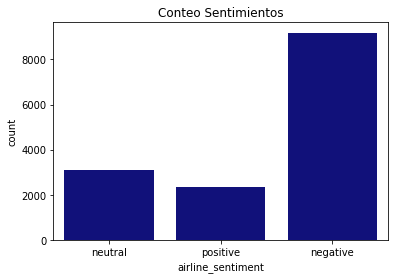

In [4]:
sns.countplot('airline_sentiment', data=data, color='darkblue')
plt.title('Conteo Sentimientos')
plt.show();

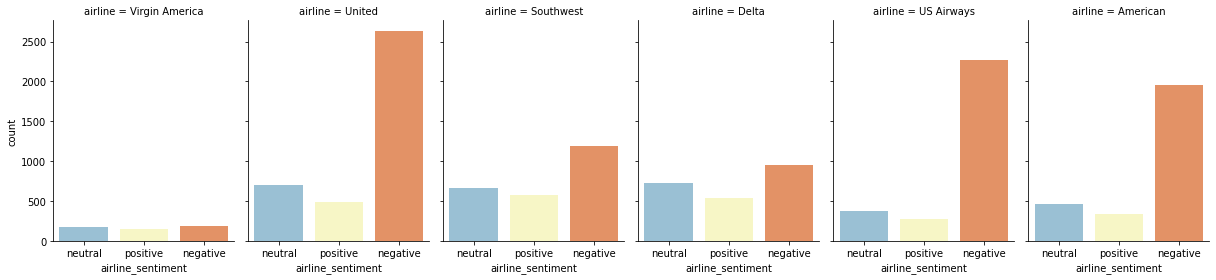

In [5]:
g = sns.catplot(x="airline_sentiment", col="airline",
                data=data, kind="count", palette="RdYlBu_r",
                height=4, aspect=.7);

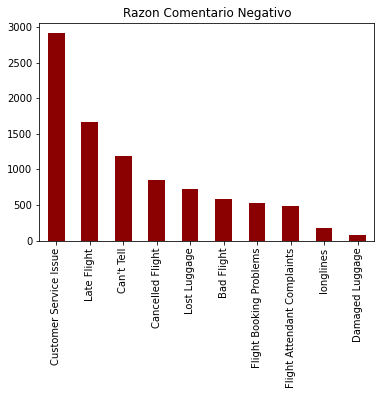

In [6]:
data.negativereason.value_counts().plot(kind='bar',
                                        title='Razon Comentario Negativo',
                                        color='darkred');

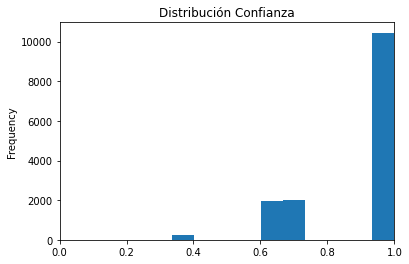

In [7]:
data.airline_sentiment_confidence.plot(kind='hist', 
                                       xlim=(0,1),
                                       title='Distribución Confianza');

In [8]:
# Exploramos los de 0.4 para abajo 
print('Positives')
print('++++++++++++++++++')
condition = ((data.airline_sentiment_confidence<=.4)&
(data.airline_sentiment=='positive'))
pos_df = data[condition].sample(5)
for i in range(len(pos_df)):
  print(pos_df.airline_sentiment_confidence.values[i])
  print(pos_df.text.values[i])
  print('------------------') 

print('\nNegatives')
print('++++++++++++++++++')
condition = ((data.airline_sentiment_confidence<=.4)&
(data.airline_sentiment=='negative'))
neg_df = data[condition].sample(5)
for i in range(len(neg_df)):
  print(neg_df.airline_sentiment_confidence.values[i])
  print(neg_df.text.values[i])
  print('------------------') 

print('\nNeutrals')
print('++++++++++++++++++')
condition = ((data.airline_sentiment_confidence<=.4)&
(data.airline_sentiment=='neutral'))
neu_df = data[condition].sample(5)
for i in range(len(neu_df)):
  print(neu_df.airline_sentiment_confidence.values[i])
  print(neu_df.text.values[i])
  print('------------------') 

Positives
++++++++++++++++++
0.3441
@united thanks -- we filled it out. How's our luck with this? Is it common?
------------------
0.3367
@united Hmmm...seems like this could be something to be changed to be more #flyerfriendly.
------------------
0.3487
@AmericanAir thank you we got on a different flight to Chicago.
------------------
0.3482
@VirginAmerica come back to #PHL already. We need you to take us out of this horrible cold. #pleasecomeback http://t.co/gLXFwP6nQH
------------------
0.35
@SouthwestAir eyes next steps for improving #inflight #Wifi - Runway Girl http://t.co/h46HT1Oz40
------------------

Negatives
++++++++++++++++++
0.3402
@united please don't take my membership away :(
------------------
0.343
@USairways E190 lands without nose gear in Houston - @Flightglobal http://t.co/Yf9NhMwyFF
------------------
0.3499
@SouthwestAir your welcome. It was the thoughts of nearly the entire plane.
------------------
0.3477
@JetBlue I appreciate the speedy response. But the longe

In [9]:
# Exploramos los de 0.8 para arriba 
print('Positives')
print('++++++++++++++++++')
condition = ((data.airline_sentiment_confidence>=.8)&
(data.airline_sentiment=='positive'))
pos_df = data[condition].sample(5)
for i in range(len(pos_df)):
  print(pos_df.airline_sentiment_confidence.values[i])
  print(pos_df.text.values[i])
  print('------------------') 

print('\nNegatives')
print('++++++++++++++++++')
condition = ((data.airline_sentiment_confidence>=.8)&
(data.airline_sentiment=='negative'))
neg_df = data[condition].sample(5)
for i in range(len(neg_df)):
  print(neg_df.airline_sentiment_confidence.values[i])
  print(neg_df.text.values[i])
  print('------------------') 

print('\nNeutrals')
print('++++++++++++++++++')
condition = ((data.airline_sentiment_confidence>=.8)&
(data.airline_sentiment=='neutral'))
neu_df = data[condition].sample(5)
for i in range(len(neu_df)):
  print(neu_df.airline_sentiment_confidence.values[i])
  print(neu_df.text.values[i])
  print('------------------') 

Positives
++++++++++++++++++
1.0
Thank you, @AmericanAir! Much appreciated.
------------------
1.0
@united Ill check it out, appreciate the response, regardless.
------------------
1.0
@united tonight you made this Fred Flintstone happy with an upgrade to 1st class. http://t.co/gKgKZLAwpR
------------------
1.0
@JetBlue thank you so much for your effort
------------------
1.0
@SouthwestAir nice work on the update!
------------------

Negatives
++++++++++++++++++
1.0
@SouthwestAir what are the chances you will be Cancelled Flighting all flights in and out of Nashville again?
------------------
1.0
@AmericanAir You are jumping the gun and Cancelled Flighting flights that could've made it before the snow. Now, more Cancelled Flightlations. It's ridiculous.
------------------
1.0
@USAirways horrible travel day w/ your airlines. My 2:20 flight to Birmingham was Cancelled Flightled w/ no notification so I couldn't get on the 4:05
------------------
1.0
@AmericanAir Cancelled Flighted our fli

In [10]:
# eliminamos la confianza menor a 0.4 
to_model_data = data[data.airline_sentiment_confidence >=.4]

# Limpieza de Texto

In [11]:
import re  # Procesamiento de Texto
import pandas as pd  
from time import time  # Medir tiempo de ejecucion
from collections import defaultdict  

import spacy  # Procesamiento NLP
from spellchecker import SpellChecker


In [12]:
# Cargamos los métodos de Spacy en Ingles 
nlp = spacy.load('en', disable=['ner', 'parser']) # Quitamos el Named Entity Recognition por facilidad de procesamiento
spell = SpellChecker() # Corrector
# Reemplazos para Tweeter
replacements = [
            '((www\.[^\s]+)|(https?://[^\s]+))', # url_replace 
            '@[^\s]+', # user_replace 
            '#([^\s]+)', # hash_replace
            "[^A-Za-z' ]+"  # eliminamos todo lo que no sea una letra
            ]
# Re nos permite compilar varias transformaciones en un solo iterador, 
# así nos evitamos iterar varias veces por el mismo documento, incrementando eficiencia. 
regex = re.compile('|'.join(r for r in replacements),re.IGNORECASE)

def limpia_tweets(tweet,spellchecker=False): 
  """ 
  Función práctica para limpiar y pre-procesar tweets. Incluye: 
  - Eliminación de Hashtags, urls y usuarios 
  - Tokenización 
  - lemmatizer 
  - corrector gramatical (inglés)
  :param tweet: String, cadena de texto, idealmente un Tweet
  :return: Una lista con tokens de tweet.  
  """
  # empezamos transformando a minúsculas
  clean_tweet = tweet.lower()
  # Limpiamos Usuario, Urls y Hashtags
  clean_tweet = regex.sub('', clean_tweet)
  # Añadimos limpieza de caracteres repetidos
  clean_tweet = re.sub(r'(.)\1+', r'\1\1', clean_tweet).split()
  if spellchecker:
    # Encuentra las que tienen errores
    misspelled = spell.unknown(clean_tweet)
    # Corregimos el tweet. 
    clean_tweet = [
        spell.correction(word) if word in misspelled else word for word in clean_tweet]
  return ' '.join(clean_tweet)

In [13]:
def cleaning(doc):
  """
  Lemmatiza y elimina stopwords
  Necesitamos un doc como lo describe spacy
  :param doc: DOC según lo describe Spacy. 
  :return: Una cadena de texto. 
  """
  
  txt = [token.lemma_ for token in doc if not token.is_stop]
  return ' '.join(txt)
# Funcion de limpieza del tweet que entrará al pipe de Spacy(NLP)
tweet_cleaning = (limpia_tweets(row) for row in to_model_data['text'])

In [14]:
#Ejemplo
limpia_tweets('hapy panda day @snafranci, really enjoying this #Gloriousafternoon', True)

'happy panda day really enjoying this'

In [15]:
from time import time  # Medir tiempo de ejecucion
t = time() # Calculamos tiempo
txt = [cleaning(doc) for doc in nlp.pipe(tweet_cleaning, # función que def antes
                                         batch_size=5000, 
                                         n_threads=-1 # usamos todos los cores
                                         )]
t_ = round((time() - t) / 60, 2) # Tiempo de ejecucion en mins
print(f'Tiempo de ejecución: {t_} mins')

Tiempo de ejecución: 0.17 mins


In [16]:
txt[:4]

['say',
 'today mean need trip',
 "aggressive blast obnoxious entertainment guest ' face amp little recourse",
 'big bad thing']

In [17]:
to_model_data['clean_text'] = txt

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """Entry point for launching an IPython kernel.


# El modelo

Para clasificar, vamos a necesitar un modelo capaz de entender y predecir las 3 clases (neg,neu,pos), por lo que tenemos una clasificación multiclase. Hemos visto que el set no esta muy equilibrado en la variable objetivo, lo que puede ser un problema. Por ello, primero probaremos un Random Forest, el cual es un modelo robusto, basado en árboles de decisión y que se maneja bien en casos con sets desbalanceados. 

Para ello, construiremos el modelo bajo el Pipeline de Sklearn

In [18]:
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
from sklearn.feature_extraction.text import TfidfTransformer
from sklearn.pipeline import Pipeline
from sklearn.utils import resample
from sklearn.model_selection import GridSearchCV
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report, accuracy_score

In [19]:
TARGET = "airline_sentiment"

X = to_model_data['clean_text']
y = to_model_data[TARGET]
# Dividimos entre set de entrenamiento y prueba
X_train, X_test, y_train, y_test = train_test_split( X, y, test_size=0.30, random_state=42, stratify=y)

In [20]:
X_train.shape # Con cuantos puntos vamos a entrenar

(10082,)

In [168]:
# Creamos el Sklearn Pipeline con todas las transformaciones mencionadas arriba 
text_clf_rf = Pipeline([
  ('vect', CountVectorizer()), 
  ('tfidf', TfidfTransformer()), # transforma por frecuencia 
  ('clf_rf', RandomForestClassifier(n_estimators=100, 
                                    verbose=True, # Verbose -> barra progreso
    oob_score=True,min_samples_split=2))
               ])
# Realizamos un entrenamiento con CV para tener certeza de los resultados
# Y también poder probar cuál modelo es el mejor. 

scoring = "f1_micro" # metric to optimize can be 'recall'
cv = 3 # cross validation
parameters = { 
  'vect__ngram_range': [(1, 1), (1, 2)],
  'tfidf__use_idf': (True, False),
  'clf_rf__n_estimators': (200, 400),
  'clf_rf__min_samples_split': (2,4)
}

# Creamos todo el pipeline para que ademas ejecute cambio de parametros 
grid = GridSearchCV(text_clf_rf, cv=cv, param_grid=parameters, 
                    scoring=scoring, n_jobs = -1)


In [169]:
# Entrenamos 
grid.fit(X_train, y_train) # Toma TIEMPO!!! 

# summarize results
print(f"Resultados en base a {scoring}")
print("Mejor: %f usando %s" % (grid.best_score_, 
    grid.best_params_))
means = grid.cv_results_['mean_test_score']
stds = grid.cv_results_['std_test_score']
params = grid.cv_results_['params']
for mean, stdev, param in zip(means, stds, params):
    print(f"Resultado medio: {mean}, SD: {stdev}  con: {param}")

[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 400 out of 400 | elapsed:   29.5s finished


Resultados en base a f1_micro
Mejor: 0.757786 usando {'clf_rf__min_samples_split': 4, 'clf_rf__n_estimators': 400, 'tfidf__use_idf': True, 'vect__ngram_range': (1, 1)}
Resultado medio: 0.7548103420183901, SD: 0.0031744485959252565  con: {'clf_rf__min_samples_split': 2, 'clf_rf__n_estimators': 200, 'tfidf__use_idf': True, 'vect__ngram_range': (1, 1)}
Resultado medio: 0.7491571445100901, SD: 0.003999415599044413  con: {'clf_rf__min_samples_split': 2, 'clf_rf__n_estimators': 200, 'tfidf__use_idf': True, 'vect__ngram_range': (1, 2)}
Resultado medio: 0.7553065803828226, SD: 0.002519255192536112  con: {'clf_rf__min_samples_split': 2, 'clf_rf__n_estimators': 200, 'tfidf__use_idf': False, 'vect__ngram_range': (1, 1)}
Resultado medio: 0.7497519398516125, SD: 0.0031089170634961234  con: {'clf_rf__min_samples_split': 2, 'clf_rf__n_estimators': 200, 'tfidf__use_idf': False, 'vect__ngram_range': (1, 2)}
Resultado medio: 0.7565956725842176, SD: 0.004249493917543637  con: {'clf_rf__min_samples_split'

# Validamos resultados

In [60]:
# Plot confusion matrix
from sklearn.metrics import confusion_matrix
import itertools

def plot_confusion_matrix(cm, classes,
                          normalize=False,
                          title='Confusion matrix',
                          cmap=plt.cm.Blues):
  """
  This function prints and plots the confusion matrix.
  Normalization can be applied by setting `normalize=True`.
  """
  if normalize:
      cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
      print("Normalized confusion matrix")
  else:
      print('Confusion matrix, without normalization')

  plt.imshow(cm, interpolation='nearest', cmap=cmap)
  plt.title(title)
  plt.colorbar()
  tick_marks = np.arange(len(classes))
  plt.xticks(tick_marks, classes, rotation=45)
  plt.yticks(tick_marks, classes)

  fmt = '.2f' if normalize else 'd'
  thresh = cm.max() / 2.
  for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
      plt.text(j, i, format(cm[i, j], fmt),
               horizontalalignment="center",
               color="white" if cm[i, j] > thresh else "black")

  plt.tight_layout()
  plt.ylabel('True label')
  plt.xlabel('Predicted label')
  plt.show()


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 400 out of 400 | elapsed:    1.1s finished



accuracy 0.7609902822767237


              precision    recall  f1-score   support

    negative       0.79      0.91      0.85      2735
     neutral       0.63      0.43      0.51       899
    positive       0.73      0.59      0.65       688

    accuracy                           0.76      4322
   macro avg       0.72      0.65      0.67      4322
weighted avg       0.75      0.76      0.75      4322

Confusion matrix, without normalization


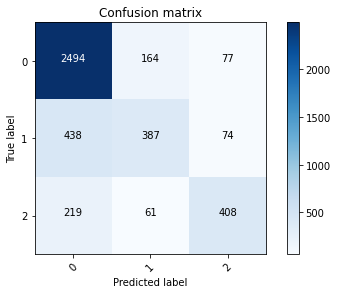

In [171]:
# Revisamos resultados del mejor modelo 
m_best = grid.best_estimator_ # mejor modelo
y_pred = m_best.predict(X_test)
# Metricas de precision
print('\naccuracy %s' % accuracy_score(y_pred, y_test))
print("\n")
print(classification_report(y_test, y_pred,))

# plot 
cm = confusion_matrix(y_test, y_pred)
plot_confusion_matrix(cm, list(range(3)))

In [183]:
# Veamos donde hemos fallado
# Show some misclassified examples
misclassified_idx = np.where(y_pred != y_test)[0]
i = np.random.choice(misclassified_idx)
print('id %s' %(i))
print(to_model_data.text.values[i])
print("Realmente es: %s Y se predijo: %s" % (y_test.values[i], y_pred[i]));

id 741
@united airlines is the absolute worst. They have no idea what they are doing. #neveragain #UnitedAirlines
Realmente es: neutral Y se predijo: negative


# ANEXO (Qué hace la pipeline de SKlearn)

In [157]:
from sklearn.feature_extraction.text import CountVectorizer
v = CountVectorizer(analyzer = "word")
train_features= v.fit_transform(X_train)
test_features=v.transform(X_test)

In [158]:
train_features

<10082x7445 sparse matrix of type '<class 'numpy.int64'>'
	with 71261 stored elements in Compressed Sparse Row format>

In [159]:
t = TfidfTransformer()
train_features = t.fit_transform(train_features)
test_features = t.transform(test_features)

In [164]:
print(train_features[:5])

  (0, 5858)	0.3228993377434181
  (0, 3857)	0.35437717528661306
  (0, 3695)	0.33507993595952323
  (0, 2868)	0.42879950299030245
  (0, 2781)	0.21004966221000754
  (0, 2685)	0.3722099037349383
  (0, 1051)	0.2150322239016278
  (0, 565)	0.3937211631028525
  (0, 323)	0.30014825245088717
  (1, 4351)	0.3302371212496812
  (1, 2546)	0.8506963145203268
  (1, 1907)	0.40897337836374725
  (2, 6657)	0.31332105876315786
  (2, 4236)	0.34840479432566057
  (2, 2949)	0.5612898468820752
  (2, 2530)	0.2547071659689163
  (2, 2467)	0.1475892035714544
  (2, 1725)	0.4089045702069542
  (2, 1680)	0.23797515338799102
  (2, 776)	0.3935788188413845
  (3, 6505)	0.4112289056947004
  (3, 4774)	0.3573882760482149
  (3, 3733)	0.5189852983036343
  (3, 728)	0.32630376861898913
  (3, 1)	0.5721402957266312


# Redes Neuronales

Las redes neuronales son complejos algoritmos de ML que buscan imitar el comportamiento del cerebro humano. Representan algunos de los grandes avances de los últimos años y son ampliamente utilizadas en NLP. Ahora, construiremos una red neuronal que nos permitirá cumplir con el mismo objetivo anterior. 

Recuerda que idealmente, se debe entrenar una red con muchos datos, y por ende, estos ejercicios requieren bastante memoria del procesador.

En este caso, vamos a construir la red con los Tweets disponibles, sin embargo, si queremos realmente tener resultados óptimos, idealmente deberíamos tener una fuente significativamente más amplia de entrenamiento


In [21]:
from keras.preprocessing.text import Tokenizer
from keras.utils.np_utils import to_categorical
from sklearn.preprocessing import LabelEncoder

from keras import models
from keras import layers
from keras import regularizers
import collections


Using TensorFlow backend.


In [22]:
NB_START_EPOCHS = 20  # Numero de epocas para entrenar 
BATCH_SIZE = 512  # Tamaño de los batches de entrenamiento
N_WORDS = 1000 # tamaño del diccionario 

In [23]:
# Keras tiene su propio módulo de texto y tokenizador
tk = Tokenizer(num_words=N_WORDS,
               lower=True, # permite agregar transformaciones 
               split=" ")
tk.fit_on_texts(X_train)
# Vemos las palabras más comunes 
print(f'Top 5 palabras más comunes:{collections.Counter(tk.word_counts).most_common(5)}')

Top 5 palabras más comunes:[('flight', 3214), ('thank', 1063), ('hour', 823), ('cancel', 749), ('service', 706)]


In [24]:
# Transformamos datos en secuencias que luego utilizará el modelo
X_train_seq = tk.texts_to_sequences(X_train) 
X_test_seq = tk.texts_to_sequences(X_test)

print(f'{X_train[2]} is converted into {X_train_seq[2]}')

today mean need trip is converted into [316, 1, 256, 6, 12, 60, 110]


In [25]:
def one_hot_seq(seqs, nb_features = N_WORDS):
  """Transforma una secuencia mediante un one hot encoding"""
  ohs = np.zeros((len(seqs), nb_features))
  for i, s in enumerate(seqs):
      ohs[i, s] = 1.
  return ohs
# realizamos el ONE HOT
X_train_oh = one_hot_seq(X_train_seq)
X_test_oh = one_hot_seq(X_test_seq)
# Imprimimos como ve la computadora los datos
print('"{}" is converted into {}'.format(X_train_seq[0], X_train_oh[0]))

"[429, 735, 31, 25, 292, 972, 30, 46, 31, 537]" is converted into [0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 1. 0. 0. 0. 0. 1. 1. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 1. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 1. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 

In [26]:
# Realizamos lo mismo para los labels 
le = LabelEncoder() # Otra funcionalidad útil de sklearn
y_train_le = le.fit_transform(y_train)
y_test_le = le.transform(y_test)
y_train_oh = to_categorical(y_train_le)
y_test_oh = to_categorical(y_test_le)
print('"{}" is converted into {}'.format(y_train[0], y_train_le[0]))
print('"{}" is converted into {}'.format(y_train_le[0], y_train_oh[0]))

"neutral" is converted into 0
"0" is converted into [1. 0. 0.]


In [27]:
"""
Realizamos otra separación de train test para modificar los hiper-parámetros 
de la red y luego comparar con este set de validación. Es decir ahora tenemos
Un set de entrenamiento, un set de prueba y otro set más pequeño de validación

"""

X_train_rest, X_valid, y_train_rest, y_valid = train_test_split(X_train_oh,
                                                                y_train_oh, 
                                                                test_size=0.1,
                                                                random_state=37)

assert X_valid.shape[0] == y_valid.shape[0]
assert X_train_rest.shape[0] == y_train_rest.shape[0]

print('Shape of validation set:',X_valid.shape)

Shape of validation set: (1009, 1000)


In [52]:
# Construimos la red -> En este caso es una red neuronal multicapa 
# Al tener pocos datos, tendrá que ser una red sencilla 
model = models.Sequential() # Creamos la red
# Añadimos la primera capa (input) que tiene como espacio inicial a N_WORDS
model.add(layers.Dense(64, activation='relu', input_shape=(N_WORDS,)))
model.add(layers.Dropout(0.4)) # añadimos una capa de olvido 
model.add(layers.Dense(16, activation='relu')) # Otra capa para la red 
model.add(layers.Dropout(0.5)) # otra capa de olvido
model.add(layers.Dense(3, activation='softmax')) # al final tenemos 3 capas, 1 por clase
model.summary() # Imprimos resultados

Model: "sequential_3"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_7 (Dense)              (None, 64)                64064     
_________________________________________________________________
dropout_5 (Dropout)          (None, 64)                0         
_________________________________________________________________
dense_8 (Dense)              (None, 16)                1040      
_________________________________________________________________
dropout_6 (Dropout)          (None, 16)                0         
_________________________________________________________________
dense_9 (Dense)              (None, 3)                 51        
Total params: 65,155
Trainable params: 65,155
Non-trainable params: 0
_________________________________________________________________


In [53]:
# Compilamos el modelo y lo dejamos listo para entrenar 
model.compile(
  optimizer='rmsprop', 
  loss='categorical_crossentropy', 
  metrics=['accuracy'])

In [54]:
# Entrenamiento
history = model.fit(X_train_rest, 
                    y_train_rest,
                    epochs=NB_START_EPOCHS,
                    batch_size=BATCH_SIZE,
                    validation_data=(X_valid, y_valid),
                    verbose=1) # Mostrar resultados por epoch

Train on 9073 samples, validate on 1009 samples
Epoch 1/20
9073/9073 [==============================] - 0s 28us/step - loss: 0.9957 - accuracy: 0.5469 - val_loss: 0.8747 - val_accuracy: 0.6343
Epoch 2/20
9073/9073 [==============================] - 0s 17us/step - loss: 0.8571 - accuracy: 0.6285 - val_loss: 0.7692 - val_accuracy: 0.6343
Epoch 3/20
9073/9073 [==============================] - 0s 16us/step - loss: 0.7878 - accuracy: 0.6433 - val_loss: 0.7181 - val_accuracy: 0.6591
Epoch 4/20
9073/9073 [==============================] - 0s 17us/step - loss: 0.7348 - accuracy: 0.6685 - val_loss: 0.6785 - val_accuracy: 0.6838
Epoch 5/20
9073/9073 [==============================] - 0s 16us/step - loss: 0.6965 - accuracy: 0.6863 - val_loss: 0.6507 - val_accuracy: 0.7185
Epoch 6/20
9073/9073 [==============================] - 0s 17us/step - loss: 0.6581 - accuracy: 0.7080 - val_loss: 0.6291 - val_accuracy: 0.7502
Epoch 7/20
9073/9073 [==============================] - 0s 16us/step - loss: 0.629

In [55]:
def eval_metric(history, metric_name='loss'):
  """
  Ploteamos el entrenamiento de la red
  :param history: Historia de entrenamienta obtenida con model.fit()
  :param metric_name: nombre de la métrica a revisar segun los atributos
    de history. Por defecto es 'loss'
  :return: Un plot
  """
  # Escogemos la métrica
  metric = history.history[metric_name]
  val_metric = history.history['val_' + metric_name]
  # Por cada epoch, tenemos un resultado
  e = range(1, NB_START_EPOCHS + 1)
  # Plotteamos
  plt.plot(e, metric, 'bo', label='Train ' + metric_name)
  plt.plot(e, val_metric, 'b', label='Validation ' + metric_name)
  plt.legend()
  plt.show()

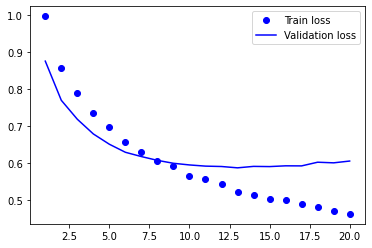

In [56]:
eval_metric(history, 'loss')

In [57]:
results = model.evaluate(X_test_oh, y_test_oh)
print('Precision del modelo : {0:.2f}%'.format(results[1]*100))

4322/4322 [==============================] - 0s 28us/step
Precision del modelo : 77.28%


Confusion matrix, without normalization


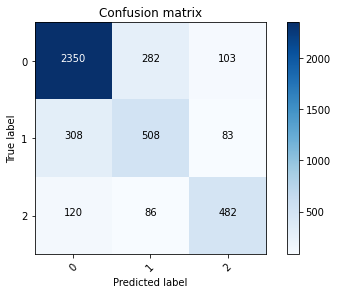

In [61]:
y_pred = model.predict(X_test_oh).argmax(axis=1)
cm = confusion_matrix(y_test_le, y_pred)
plot_confusion_matrix(cm, list(range(3)))

In [63]:
# Veamos donde hemos fallado
misclassified_idx = np.where(y_pred != y_test_le)[0] # escogemos los fallos
i = np.random.choice(misclassified_idx) # Randómicamente elegimos uno
print('id %s' %(i))
print(to_model_data.text.values[i])
print("Realmente es: %s Y se predijo: %s" % (y_test_le[i], y_pred[i]));

id 1860
@united last week we also had maintenance issues and a flat tire. Another flight last week was Cancelled Flighted. Your track record is the WORST!
Realmente es: 0 Y se predijo: 1


In [ ]:
# 0 neutral 
# 1 neg 
# 2 pos